#Import necessary libraries


In [1]:
import pandas as pd  # pandas for data manipulation (e.g., handling datasets)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Tools for converting text to numerical data
from sklearn.base import TransformerMixin  # Base class for creating custom transformers
from sklearn.pipeline import Pipeline  # For chaining preprocessing steps and classifiers together
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

In [2]:
#load the data
amazon_data =pd.read_csv("/content/amazon_alexa.tsv", sep="\t")
amazon_data.head(5)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
amazon_data.shape

(3150, 5)

In [4]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
amazon_data.feedback.value_counts()

,count
feedback,
1,2893
0,257


In [6]:
amazon_data.isna().sum().sort_values(ascending=False)

,0
verified_reviews,1
rating,0
date,0
variation,0
feedback,0


In [7]:
#amazon_data = amazon_data.dropna(subset=['verified_reviews'])

In [8]:
amazon_data.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


# Data Visualization

**Visualizing feedback Counts**

<ipython-input-9-974329e11689>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feedback_counts.index, y=feedback_counts.values, palette='viridis')


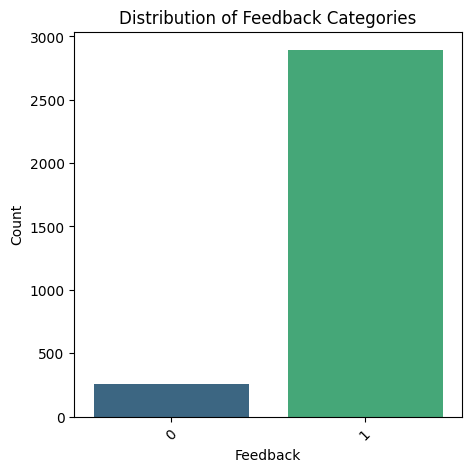

In [9]:
# Create a bar plot to visualize the distribution of feedback
# Get the counts of feedback values
feedback_counts = amazon_data.feedback.value_counts()

plt.figure(figsize=(5, 5))
sns.barplot(x=feedback_counts.index, y=feedback_counts.values, palette='viridis')
plt.title("Distribution of Feedback Categories")
plt.xlabel("Feedback")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

**Visualizing summary statistics**

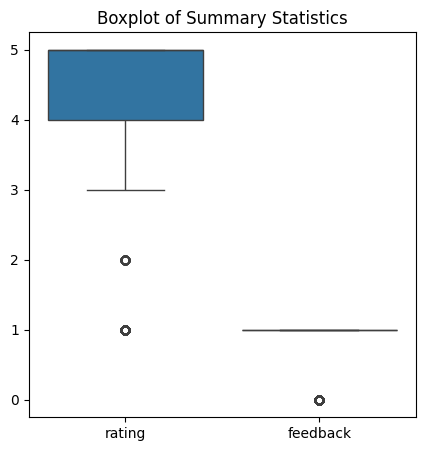

In [10]:
# Generate summary statistics using describe()
summary_stats = amazon_data.describe()

# Create a boxplot to visualize the distribution of numerical columns
plt.figure(figsize=(5, 5))
sns.boxplot(data=amazon_data)
plt.title("Boxplot of Summary Statistics")
plt.show()

**Visualizing rating Distribution**

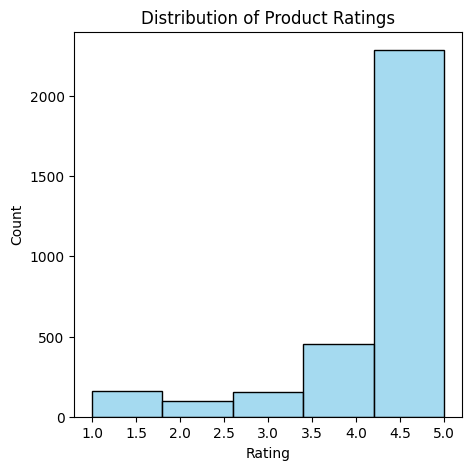

In [11]:
# Visualize the distribution of ratings
plt.figure(figsize=(5, 5))
sns.histplot(amazon_data['rating'], bins=5, kde=False, color='skyblue')
plt.title("Distribution of Product Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

**Visualizing Date (date) Over Time**
*If the date column contains timestamps, you can visualize how reviews or feedback change over time. First, convert the date column to a datetime type:*

<ipython-input-12-5a9edcbbeb72>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  amazon_data['date'] = pd.to_datetime(amazon_data['date'])


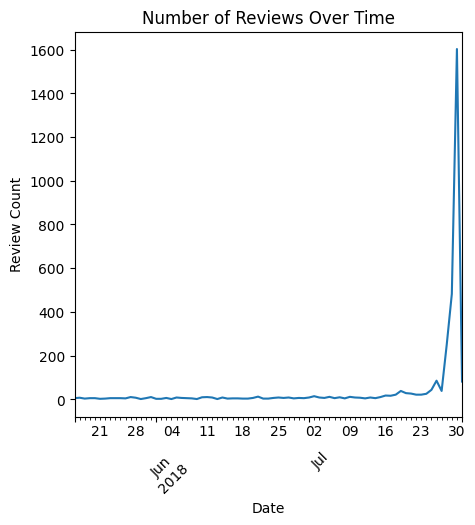

In [12]:
# Convert 'date' column to datetime type
amazon_data['date'] = pd.to_datetime(amazon_data['date'])

# Plot the number of reviews over time
plt.figure(figsize=(10, 6))
amazon_data['date'].value_counts().sort_index().plot(figsize=(5, 5))
plt.title("Number of Reviews Over Time")
plt.xlabel("Date")
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.show()

**Visualizing variation Counts** *If variation refers to different product variations, a bar plot can show the count of each variation*

<ipython-input-13-99056db704db>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=variation_counts.index, y=variation_counts.values, palette='Set2')


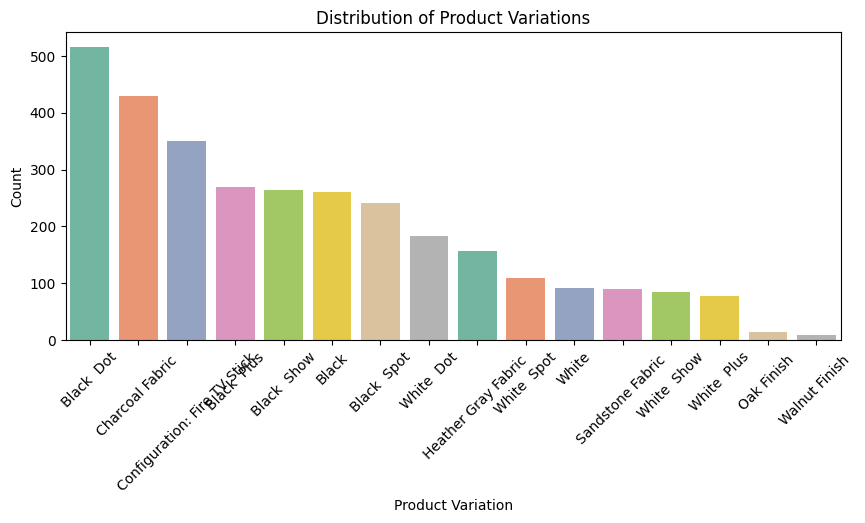

In [13]:
# Get the count of product variations
variation_counts = amazon_data['variation'].value_counts()

# Plot the variation distribution
plt.figure(figsize=(10, 4))
sns.barplot(x=variation_counts.index, y=variation_counts.values, palette='Set2')
plt.title("Distribution of Product Variations")
plt.xlabel("Product Variation")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [60]:
print(amazon_data['variation'].value_counts())
print(amazon_data['rating'].value_counts())
print(amazon_data['feedback'].value_counts())

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64
rating
5    2286
4     455
1     161
3     152
2      96
Name: count, dtype: int64
verified_reviews
                                                                                                                                                                                                                                                                                                

# Text preprocessing


**Explanation of the Steps in the Function**


**(1)re.sub(r'\W', ' ', str(text)):**
This uses a regular expression to replace all non-word characters (anything that's not a letter or number) with spaces. The \W pattern matches anything that's not a word character.



**(2)re.sub(r'\s+[a-zA-Z]\s+', ' ', text):**
This removes any single alphabetic characters (e.g., "a", "I") that are surrounded by spaces. These are often not meaningful in text processing.



**(3)re.sub(r'\^[a-zA-Z]\s+', ' ', text):**
This removes any single alphabetic characters at the start of the string (e.g., removing stray characters like 'b' or 'I' from the beginning).



**(4)re.sub(r'\s+', ' ', text, flags=re.I):**
This consolidates multiple consecutive spaces into a single space.



**(5)re.sub(r'^b\s+', '', text):**
This removes the leading letter 'b' from a string (if it's the first character) that might occur in specific cases (e.g., "b I am happy" becomes "I am happy").



**(6)text.lower():**
Converts all characters in the text to lowercase, ensuring uniformity and preventing differentiation between "Hello" and "hello".



**(7)text.split():**
This splits the cleaned text into individual words (tokens).



**(8)[lemmatizer.lemmatize(word) for word in text]:**
This applies the NLTK WordNetLemmatizer to each word, converting words like "running" to their base form "run". Lemmatization is more advanced than stemming as it ensures words are reduced to meaningful base forms.



**(9)' '.join(text):**
Finally, the lemmatized words are joined back into a single string, where each word is separated by a space.


In [14]:
import nltk

# Download the WordNet corpus
nltk.download('wordnet')

# Additionally, download 'omw-1.4' for better lemmatization coverage
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [21]:
import string
import spacy
import re
from nltk.stem import WordNetLemmatizer

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = spacy.load('en_core_web_sm')

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    lemmatizer = WordNetLemmatizer()

    # Cleaning and preprocessing steps
    text = re.sub(r'\W', ' ', str(sentence))  # Replace non-word characters with spaces (sentence -> text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # Remove leading single characters
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Replace multiple spaces with one
    text = re.sub(r'^b\s+', '', text)  # Remove leading 'b'
    text = text.lower()  # Convert text to lowercase
    text = text.split()  # Split text into words
    text = [lemmatizer.lemmatize(word) for word in text]  # Lemmatize each word
    return ' '.join(text)  # Return cleaned and lemmatized text as a single string


###Creating a Custom Text Preprocessing Class (predictors)
In machine learning, text data typically needs to be cleaned and preprocessed before it can be used in a model. The predictors class is a custom text preprocessing class that you define to clean and transform your text data.

To integrate this preprocessing step into an sklearn pipeline, you can use the TransformerMixin class from sklearn.base. Here's a detailed explanation of the code and its components:

###What is TransformerMixin?
The TransformerMixin class from the sklearn.base module is a convenient base class for building transformers (custom data transformation steps). It provides the fit() and transform() methods, which are needed to make the class compatible with scikit-learn's pipelines.

**fit():** Learns from the data (if necessary). For text preprocessing, it might not need to learn anything, so this method can just return self.
**transform():** Transforms the input data. In our case, it will clean the text.

In [22]:
# Custom transformer using spaCy
# Basic function to clean the text
def clean_text(text):
    # Check if text is a string; otherwise, convert to empty string
    if not isinstance(text, str):
        text = ""
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Ensure no NaNs in the dataset
X = amazon_data['verified_reviews'].fillna("")  # Replace NaNs with an empty string
y = amazon_data['feedback']



**The line of code you provided uses CountVectorizer from scikit-learn to convert text data into a bag-of-words (BoW) model. Here’s a breakdown of the code:**
**(1) tokenizer=spacy_tokenizer:** This specifies that you’re using a custom tokenizer (spacy_tokenizer) instead of the default one. spacy_tokenizer is typically a function that uses the spaCy library to tokenize the text, which might provide better tokenization by handling punctuation, stopwords, and other linguistic aspects more efficiently.

**(2) ngram_range=(1,1):** This specifies the range of n-grams to use when tokenizing text.

ngram_range=(1,1) means unigrams (single words) only. If you set it to (1,2), it would generate both unigrams and bigrams (pairs of consecutive words).
In general, n-grams are useful for capturing word combinations, e.g., unigrams are individual words, and bigrams capture pairs like "good product."

In [23]:
bow_vector = CountVectorizer(tokenizer =  spacy_tokenizer, ngram_range=(1,1))

**The line of code you provided creates a TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer using spaCy as the tokenizer:**
Breakdown of the Code:
**TfidfVectorizer: **This is a feature extraction method from scikit-learn that converts a collection of text documents into a matrix of TF-IDF features. It helps in converting text data into numerical format, emphasizing important words based on their frequency across documents.

**tokenizer=spacy_tokenizer:** This argument allows you to use a custom tokenizer function, in this case, spacy_tokenizer. This means the text will be tokenized using spaCy's advanced tokenization methods, which can handle punctuation, stopwords, lemmatization, and more, as opposed to the default tokenizer provided by TfidfVectorizer.

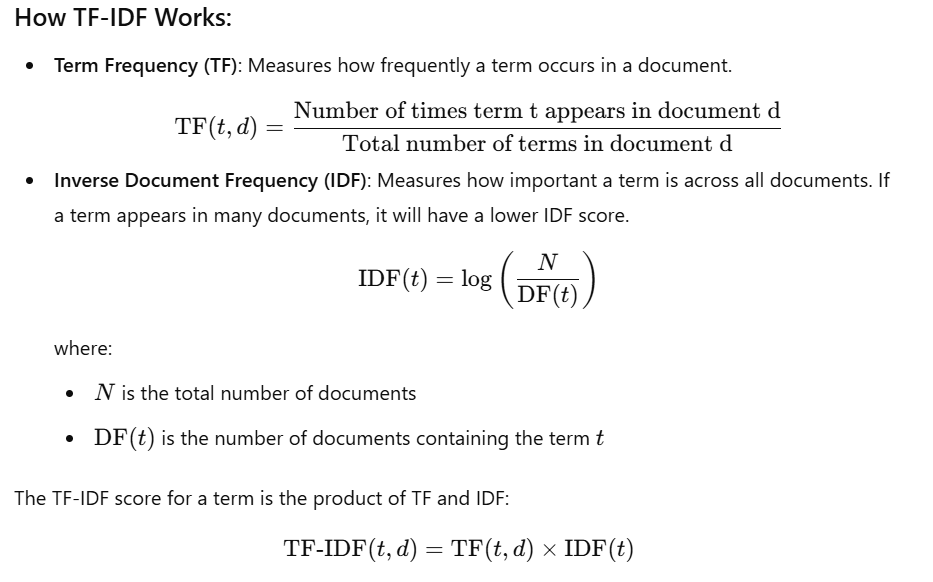

In [24]:
tfidf_vector = TfidfVectorizer(tokenizer =  spacy_tokenizer)

## split *dataset* into training and testing

###Key Points:
**(1)train_test_split:**This function is used to randomly split the dataset into training and testing subsets.
test_size=0.3 means that 30% of the dataset will be used as the testing set, while 70% will be used for training.

**(2)Input Features (X):**
The column verified_reviews contains the review text, which you want to analyze.

**(3)Target Labels (ylabels):**
The column feedback contains the labels (e.g., 0 or 1 for negative/positive feedback).

**(4)Resulting Variables:**
X_train: The training set for features (text reviews).
X_test: The testing set for features (text reviews).
y_train: The training set for labels (feedback).
y_test: The testing set for labels (feedback).

###Additional Notes:
**random_state=42**: Ensures that the split is reproducible. Without this, the data split will vary each time you run the code.

**Balancing:** If your feedback column has an imbalance (e.g., more positive than negative), consider stratified sampling:

In [69]:
from sklearn.model_selection import train_test_split

X = amazon_data['verified_reviews'] # the features we want to analyze
ylabels = amazon_data['feedback'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

**(1)-Define the Logistic Regression Model**
Create an instance of Logistic Regression.

**(2)-Create the Pipeline**
Define the pipeline that combines the text preprocessing, TF-IDF vectorization, and logistic regression model:

**(3)-Train the Model**
Fit the model on your training data (X_train and y_train)



###Model Explanation
**Text Cleaning (predictors):** Preprocesses the raw text (removes extra spaces, converts to lowercase).

**TF-IDF Vectorization (TfidfVectorizer):** Converts text into a numerical matrix based on term frequency and inverse document frequency (TF-IDF).

**Logistic Regression Model (LogisticRegression):** Trains on the TF-IDF features to predict labels (positive or negative).


###Considerations
**Increased Iterations:** max_iter=1000 ensures more iterations for convergence if needed.

**Solver Choice:** solver='liblinear' is suitable for smaller datasets.

**Tokenizer:** Disabled default tokenizer in TfidfVectorizer since the custom tokenizer (predictors) is being used.

In [54]:
# Create pipeline using Bag of Words
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
# Create pipeline using Bag of Words
# Increased max_iter and added StandardScaler
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])


# model generation
pipe.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7ac5c2a7de40>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7ac6690e6b90>)),
                ('classifier', LogisticRegression())])

**Use pipe.predict()** to make predictions on new data.
Evaluate the model using appropriate metrics like accuracy, precision, recall, etc.


In [55]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9174603174603174
Logistic Regression Precision: 0.9267241379310345
Logistic Regression Recall: 0.9885057471264368
